In [68]:
import os
import mlflow
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [69]:
df = pd.read_pickle('../data/clean_data.pkl').sample(frac = 0.1, random_state = 2)
df.info()
#df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 2285 entries, 1626 to 22026
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Date           2285 non-null   object  
 1   Gender         2285 non-null   category
 2   Annual Income  2285 non-null   float32 
 3   Dealer_Name    2285 non-null   category
 4   Company        2285 non-null   category
 5   Model          2285 non-null   category
 6   Color          2285 non-null   category
 7   Price ($)      2285 non-null   float32 
 8   Dealer_No      2285 non-null   object  
 9   Body Style     2285 non-null   category
 10  Dealer_Region  2285 non-null   category
 11  Config         2285 non-null   category
 12  Month          2285 non-null   int32   
 13  Year           2285 non-null   int32   
 14  Price/Income   2285 non-null   float32 
 15  norm_Income    2285 non-null   float32 
 16  norm_Price     2285 non-null   float32 
dtypes: category(8), float32(5), int32(

In [70]:
df = df.rename(columns={'Price ($)': 'target'})
df = df.drop(columns = ['Date', 'Month'])

In [71]:
df

,Gender,Annual Income,Dealer_Name,Company,Model,Color,target,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
1626,Male,900000.0,Iceberg Rentals,Mercury,Mercury Sable,Red,39000.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.043333,0.079529,0.440191
723,Female,13500.0,Race Car Help,Toyota,Toyota Land Cruiser,Black,21000.0,78758-7841,SUV,Austin,DoubleÂ Overhead Camshaft Auto,2022,1.555556,0.000306,0.224880
19756,Female,620000.0,Clay Johnson Auto Sales,Dodge,Dodge Intrepid,Black,11001.0,78758-7841,Sedan,Austin,Overhead Camshaft Manual,2023,0.017744,0.054506,0.105275
20920,Male,13500.0,McKinney Dodge Chrysler Jeep,Audi,Audi A6,Pale White,24000.0,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2023,1.777778,0.000306,0.260766
10420,Female,13500.0,New Castle Ford Lincoln Mercury,Nissan,Nissan Altima,Pale White,21001.0,60504-7114,Hatchback,Aurora,DoubleÂ Overhead Camshaft Auto,2022,1.555630,0.000306,0.224892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17526,Male,657500.0,Ryder Truck Rental and Leasing,Cadillac,Cadillac Eldorado,Black,29500.0,06457-3834,Passenger,Middletown,Overhead Camshaft Manual,2023,0.044867,0.057857,0.326555
10550,Male,903000.0,Suburban Ford,Lexus,Lexus LS400,Pale White,27001.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.029901,0.079797,0.296663
6414,Male,981000.0,Saab-Belle Dodge,Saturn,Saturn LS,Pale White,51000.0,60504-7114,Sedan,Aurora,DoubleÂ Overhead Camshaft Auto,2022,0.051988,0.086767,0.583732
23086,Male,600000.0,Clay Johnson Auto Sales,Chrysler,Chrysler Cirrus,Red,12001.0,78758-7841,Passenger,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.020002,0.052719,0.117237


In [72]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size = 0.25, random_state = 2)

In [73]:
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.to_list()
cat_features

['Gender',
 'Dealer_Name',
 'Company',
 'Model',
 'Color',
 'Dealer_No ',
 'Body Style',
 'Dealer_Region',
 'Config']

In [74]:
num_features = X_train.select_dtypes(include = ['number']).columns.to_list()
num_features

['Annual Income', 'Year', 'Price/Income', 'norm_Income', 'norm_Price']

In [75]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)
regressor = CatBoostRegressor()

## Column transformer

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [77]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 3.71ms	remaining: 3.71s
1:	learn: 13360.8881409	total: 5.26ms	remaining: 2.62s
2:	learn: 12884.1574913	total: 11.6ms	remaining: 3.84s
3:	learn: 12398.4071229	total: 14ms	remaining: 3.5s
4:	learn: 11960.2152363	total: 15.6ms	remaining: 3.11s
5:	learn: 11532.2484021	total: 19.2ms	remaining: 3.19s
6:	learn: 11096.6129748	total: 25.1ms	remaining: 3.56s
7:	learn: 10694.6695614	total: 27.5ms	remaining: 3.41s
8:	learn: 10311.4520848	total: 30.2ms	remaining: 3.32s
9:	learn: 9913.7881842	total: 34.3ms	remaining: 3.4s
10:	learn: 9558.4684907	total: 38ms	remaining: 3.41s
11:	learn: 9198.5806291	total: 41.5ms	remaining: 3.42s
12:	learn: 8879.2997198	total: 46.2ms	remaining: 3.51s
13:	learn: 8575.6318516	total: 53.5ms	remaining: 3.77s
14:	learn: 8270.4110308	total: 63.2ms	remaining: 4.15s
15:	learn: 7995.0992161	total: 66ms	remaining: 4.06s
16:	learn: 7693.9306953	total: 71.1ms	remaining: 4.11s
17:	learn: 7431.6369104	total: 79.1ms	remain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc89597e20>)])

In [78]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 147.92809561161928,
 'mape': 0.005636038616034008,
 'mse': 186539.68771819372}

In [79]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [80]:
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

## Логирование

In [81]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [82]:
req_file = '../requirements.txt'
art = '../comment.txt'

In [83]:
params_dict = pipeline.get_params()

In [84]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/39b289b927184819a02929578a19cdc4.
2024/11/21 00:59:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


## Удаление run, experiments

In [85]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
mlflow.search_runs(experiment_names=[EXPERIMENT_NAME],)


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mse,metrics.mape,metrics.mae,metrics.training_mean_squared_error,...,params.model__min_samples_leaf,params.model__n_jobs,params.model__warm_start,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.estimator_name,tags.estimator_class
0,39b289b927184819a02929578a19cdc4,1,FINISHED,mlflow-artifacts:/1/39b289b927184819a02929578a...,2024-11-20 21:59:12.446000+00:00,2024-11-20 21:59:12.922000+00:00,186539.687718,0.005636,147.928096,NaN,...,None,None,None,LOCAL,baseline model,"[{""run_id"": ""39b289b927184819a02929578a19cdc4""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
1,029c5fc17e3d495781b77ad4419b75ed,1,FINISHED,mlflow-artifacts:/1/029c5fc17e3d495781b77ad441...,2024-11-19 10:34:53.192000+00:00,2024-11-19 10:34:53.561000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,LOCAL,final_model,"[{""run_id"": ""029c5fc17e3d495781b77ad4419b75ed""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
2,72553c5b631e4d42ae303a3ae1ab190d,1,FINISHED,mlflow-artifacts:/1/72553c5b631e4d42ae303a3ae1...,2024-11-19 10:34:38.393000+00:00,2024-11-19 10:34:38.975000+00:00,24863.326110,0.001920,51.974615,NaN,...,None,None,None,LOCAL,optuna_model,"[{""run_id"": ""72553c5b631e4d42ae303a3ae1ab190d""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
3,7f3ccdcf67cf438982504c3f3308cdb2,1,FINISHED,mlflow-artifacts:/1/7f3ccdcf67cf438982504c3f33...,2024-11-19 10:33:57.322000+00:00,2024-11-19 10:33:57.844000+00:00,5119.415200,0.001964,45.277025,NaN,...,None,None,None,LOCAL,SFS,"[{""run_id"": ""7f3ccdcf67cf438982504c3f3308cdb2""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
4,9f5fe668693841258090c935dcdb00b3,1,FINISHED,mlflow-artifacts:/1/9f5fe668693841258090c935dc...,2024-11-19 10:33:25.627000+00:00,2024-11-19 10:33:26.098000+00:00,111985.618886,0.006077,145.405590,NaN,...,None,None,None,LOCAL,fe_sklearn,"[{""run_id"": ""9f5fe668693841258090c935dcdb00b3""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
5,be16bb998df045dcbaca634df5ca4083,1,FINISHED,mlflow-artifacts:/1/be16bb998df045dcbaca634df5...,2024-11-19 10:30:29.446000+00:00,2024-11-19 10:30:29.489000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,LOCAL,no_model,None,mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
6,b91b02516eed4b738dd477a432f12619,1,FINISHED,mlflow-artifacts:/1/b91b02516eed4b738dd477a432...,2024-11-19 10:30:28.952000+00:00,2024-11-19 10:30:29.357000+00:00,12889.062201,0.002554,55.925690,NaN,...,1,None,False,LOCAL,smaller_model,"[{""run_id"": ""b91b02516eed4b738dd477a432f12619""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
7,9f728c5e4e894810bd114b5ad4edb583,1,FINISHED,mlflow-artifacts:/1/9f728c5e4e894810bd114b5ad4...,2024-11-19 10:30:19.312000+00:00,2024-11-19 10:30:28.683000+00:00,NaN,NaN,NaN,10078.749246,...,None,None,None,LOCAL,auto,"[{""run_id"": ""9f728c5e4e894810bd114b5ad4edb583""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,Pipeline,sklearn.pipeline.Pipeline
8,a8fe0895c8014c42855724ddf7374f25,1,FINISHED,mlflow-artifacts:/1/a8fe0895c8014c42855724ddf7...,2024-11-19 10:30:15.652000+00:00,2024-11-19 10:30:18.474000+00:00,186539.687718,0.005636,147.928096,NaN,...,None,None,None,LOCAL,baseline model,"[{""run_id"": ""a8fe0895c8014c42855724ddf7374f25""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None
9,f62f5982a4f441e399fc05092472d00a,1,FINISHED,mlflow-artifacts:/1/f62f5982a4f441e399fc050924...,2024-11-18 20:44:35.971000+00:00,2024-11-18 20:44:36.584000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,LOCAL,final_model,"[{""run_id"": ""f62f5982a4f441e399fc05092472d00a""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,None,None


## Автологирование

In [86]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/21 00:59:13 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/21 00:59:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever the

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 3.47ms	remaining: 3.46s
1:	learn: 13360.8881409	total: 5.46ms	remaining: 2.72s
2:	learn: 12884.1574913	total: 6.6ms	remaining: 2.19s
3:	learn: 12398.4071229	total: 7.94ms	remaining: 1.98s
4:	learn: 11960.2152363	total: 8.88ms	remaining: 1.77s
5:	learn: 11532.2484021	total: 9.52ms	remaining: 1.58s
6:	learn: 11096.6129748	total: 10.3ms	remaining: 1.46s
7:	learn: 10694.6695614	total: 11.1ms	remaining: 1.37s
8:	learn: 10311.4520848	total: 12ms	remaining: 1.32s
9:	learn: 9913.7881842	total: 12.7ms	remaining: 1.26s
10:	learn: 9558.4684907	total: 13.6ms	remaining: 1.22s
11:	learn: 9198.5806291	total: 14.4ms	remaining: 1.19s
12:	learn: 8879.2997198	total: 15.2ms	remaining: 1.15s
13:	learn: 8575.6318516	total: 16.1ms	remaining: 1.14s
14:	learn: 8270.4110308	total: 17.4ms	remaining: 1.14s
15:	learn: 7995.0992161	total: 18.4ms	remaining: 1.13s
16:	learn: 7693.9306953	total: 19.4ms	remaining: 1.12s
17:	learn: 7431.6369104	total: 23.8ms	r

2024/11/21 00:59:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/21 00:59:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run auto at: http://127.0.0.1:5000/#/experiments/1/runs/d893b

In [87]:
mlflow.sklearn.autolog(disable=True)

## Model #2

In [88]:
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [89]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [90]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 54.9077411170743,
 'mape': 0.00239241876476553,
 'mse': 17226.336721812237}

In [91]:
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/8d62b5f5dff14eb4b9f24daef7bc01e3.
2024/11/21 00:59:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [92]:
RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.log_artifact(art)


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run no_model at: http://127.0.0.1:5000/#/experiments/1/runs/2ce932b686264f02aef2f7a05afc79d2.
2024/11/21 00:59:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [93]:
model_reg = mlflow.search_registered_models()
model_reg[0]

<RegisteredModel: aliases={}, creation_timestamp=1731961042224, description='', last_updated_timestamp=1732012378051, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1732012378051, current_stage='None', description='', last_updated_timestamp=1732012378051, name='estate_model_rf', run_id='b12d9b11f7684540be412db26773c008', run_link='', source='mlflow-artifacts:/1/b12d9b11f7684540be412db26773c008/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='estate_model_rf', tags={}>

In [94]:
model_name = REGISTRY_MODEL_NAME
model_version = 1

model_loaded = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [95]:
model_loaded.predict(X_test.iloc[0:1])

array([21001.])

In [96]:
y_test.iloc[0]

21001.0

# Feature engineering

## Sklearn

In [97]:
run_id = 'b12d9b11f7684540be412db26773c008' # Указываем run id
mlflow.register_model(f"runs:/{run_id}/models", REGISTRY_MODEL_NAME)

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/21 00:59:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 2
Created version '2' of model 'estate_model_rf'.


<ModelVersion: aliases=[], creation_timestamp=1732139965206, current_stage='None', description='', last_updated_timestamp=1732139965206, name='estate_model_rf', run_id='b12d9b11f7684540be412db26773c008', run_link='', source='mlflow-artifacts:/1/b12d9b11f7684540be412db26773c008/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>

In [98]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression

In [99]:
X_train_sklearn = X_train.copy()

In [100]:
num_features = ["Annual Income"]

In [101]:
transformers=[
    ('num', s_scaler, num_features),  # преобразования для числовых признаков
    ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ("kbin", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform"), num_features)
]

In [102]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
X_train_sklearn = preprocessor.fit_transform(X_train_sklearn)

column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names.csv", index=False)  # Сохраняем в файл

X_transformed_df = pd.DataFrame(X_train_sklearn, columns=preprocessor.get_feature_names_out())


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)
])

In [103]:
model_sklearn = pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13806.5705878	total: 1.07ms	remaining: 1.07s
1:	learn: 13295.9835548	total: 1.99ms	remaining: 995ms
2:	learn: 12771.7163493	total: 3.42ms	remaining: 1.14s
3:	learn: 12285.7337929	total: 4.37ms	remaining: 1.09s
4:	learn: 11815.7085981	total: 5.18ms	remaining: 1.03s
5:	learn: 11409.4593153	total: 6.18ms	remaining: 1.02s
6:	learn: 10981.9119425	total: 7.29ms	remaining: 1.03s
7:	learn: 10585.1119722	total: 8.37ms	remaining: 1.04s
8:	learn: 10181.7719640	total: 9.09ms	remaining: 1s
9:	learn: 9795.2722637	total: 9.97ms	remaining: 987ms
10:	learn: 9432.9570742	total: 10.9ms	remaining: 979ms
11:	learn: 9084.2045650	total: 11.8ms	remaining: 969ms
12:	learn: 8767.3651440	total: 12.7ms	remaining: 963ms
13:	learn: 8439.5703082	total: 13.6ms	remaining: 956ms
14:	learn: 8127.2640212	total: 14.4ms	remaining: 945ms
15:	learn: 7843.6923591	total: 15.2ms	remaining: 934ms
16:	learn: 7535.7677957	total: 16ms	remaining: 923ms
17:	learn: 7269.2781812	total: 16.7ms	rem

In [104]:
model_sklearn

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region', 'Config']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Annual Income'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc89597e20>)])

In [105]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 146.62240450402035,
 'mape': 0.005258951514458625,
 'mse': 176696.74144002135}

In [106]:
RUN_NAME = 'fe_sklearn'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("column_names.csv", artifact_path="columns")
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/f36ce31388e44d149c85835c321252c4.
2024/11/21 00:59:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [107]:
X_train.head(10)

,Gender,Annual Income,Dealer_Name,Company,Model,Color,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
12275,Male,13500.0,Enterprise Rent A Car,Mercury,Mercury Grand Marquis,Pale White,60504-7114,SUV,Aurora,Overhead Camshaft Manual,2023,1.185185,0.000306,0.165072
2786,Male,13500.0,Tri-State Mack Inc,Mercedes-B,Mercedes-B SL-Class,Pale White,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,1.925926,0.000306,0.284689
21429,Male,13500.0,Progressive Shippers Cooperative Association No,Oldsmobile,Oldsmobile Silhouette,Pale White,53546-9427,Sedan,Janesville,Overhead Camshaft Manual,2023,2.518593,0.000306,0.380395
18593,Male,5500000.0,Tri-State Mack Inc,Audi,Audi A6,Black,85257-3102,SUV,Greenville,Overhead Camshaft Manual,2023,0.004545,0.490613,0.272727
22446,Female,425000.0,Scrivener Performance Engineering,Mitsubishi,Mitsubishi Montero Sport,Red,38701-8047,Hardtop,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.091765,0.037080,0.440191
21501,Female,13500.0,Suburban Ford,Ford,Ford Crown Victoria,Pale White,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,2.148148,0.000306,0.320574
7122,Female,1150000.0,McKinney Dodge Chrysler Jeep,Pontiac,Pontiac Sunfire,Red,85257-3102,Sedan,Scottsdale,Overhead Camshaft Manual,2022,0.037391,0.101870,0.488038
20537,Male,13500.0,Suburban Ford,Dodge,Dodge Ram Wagon,Black,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,1.629630,0.000306,0.236842
23684,Male,985500.0,Chrysler Plymouth,Jeep,Jeep Grand Cherokee,Pale White,53546-9427,SUV,Janesville,Overhead Camshaft Manual,2023,0.015728,0.087170,0.159091
19204,Male,830000.0,Suburban Ford,Volvo,Volvo C70,Pale White,53546-9427,Hatchback,Janesville,Overhead Camshaft Manual,2023,0.028916,0.073273,0.260766


In [108]:
X_transformed_df.head(10)

,num__Annual Income,cat__Gender,cat__Dealer_Name,cat__Company,cat__Model,cat__Color,cat__Dealer_No,cat__Body Style,cat__Dealer_Region,cat__Config,kbin__Annual Income,remainder__Year,remainder__Price/Income,remainder__norm_Income,remainder__norm_Price
0,-1.184533,1.0,8.0,17.0,86.0,1.0,3.0,3.0,0.0,1.0,0.0,2023.0,1.185185,0.000306,0.165072
1,-1.184533,1.0,26.0,16.0,82.0,1.0,5.0,3.0,6.0,1.0,0.0,2022.0,1.925926,0.000306,0.284689
2,-1.184533,1.0,18.0,20.0,109.0,1.0,2.0,4.0,3.0,1.0,0.0,2023.0,2.518593,0.000306,0.380395
3,6.386611,1.0,26.0,1.0,4.0,0.0,5.0,3.0,2.0,1.0,2.0,2023.0,0.004545,0.490613,0.272727
4,-0.616680,0.0,23.0,18.0,97.0,2.0,1.0,0.0,1.0,0.0,0.0,2023.0,0.091765,0.037080,0.440191
5,-1.184533,0.0,25.0,8.0,45.0,1.0,2.0,2.0,3.0,0.0,0.0,2023.0,2.148148,0.000306,0.320574
6,0.383790,0.0,12.0,22.0,118.0,2.0,5.0,4.0,6.0,1.0,0.0,2022.0,0.037391,0.101870,0.488038
7,-1.184533,1.0,25.0,7.0,41.0,0.0,2.0,2.0,3.0,0.0,0.0,2023.0,1.629630,0.000306,0.236842
8,0.156787,1.0,3.0,13.0,66.0,1.0,2.0,3.0,3.0,1.0,0.0,2023.0,0.015728,0.087170,0.159091
9,-0.057797,1.0,25.0,29.0,146.0,1.0,2.0,1.0,3.0,1.0,0.0,2023.0,0.028916,0.073273,0.260766


In [109]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [110]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_transformed_df,y_train)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [111]:
selected_features_sfs = X_transformed_df.loc[:, sfs.k_feature_names_]
selected_features_sfs

,kbin__Annual Income,remainder__Year,remainder__norm_Price
0,0.0,2023.0,0.165072
1,0.0,2022.0,0.284689
2,0.0,2023.0,0.380395
3,2.0,2023.0,0.272727
4,0.0,2023.0,0.440191
...,...,...,...
1708,0.0,2022.0,0.350478
1709,0.0,2022.0,0.296651
1710,1.0,2023.0,0.117225
1711,0.0,2023.0,0.180622


In [112]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['kbin__Annual Income', 'remainder__Year', 'remainder__norm_Price']

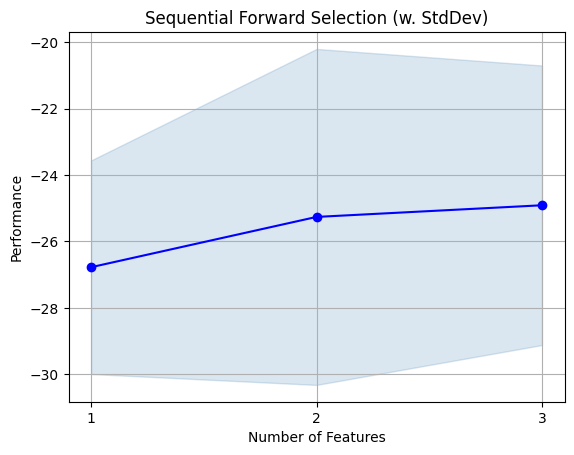

In [113]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [114]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [115]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13793.0749520	total: 707us	remaining: 707ms
1:	learn: 13263.2365697	total: 1.4ms	remaining: 697ms
2:	learn: 12746.6390443	total: 2.09ms	remaining: 695ms
3:	learn: 12266.3784419	total: 3.02ms	remaining: 751ms
4:	learn: 11825.5846914	total: 3.4ms	remaining: 676ms
5:	learn: 11387.2784122	total: 4.05ms	remaining: 671ms
6:	learn: 10940.4385886	total: 4.76ms	remaining: 676ms
7:	learn: 10507.0585811	total: 5.28ms	remaining: 655ms
8:	learn: 10104.3165149	total: 5.92ms	remaining: 652ms
9:	learn: 9698.1883153	total: 6.54ms	remaining: 648ms
10:	learn: 9342.1429942	total: 7.03ms	remaining: 632ms
11:	learn: 8985.3007079	total: 7.43ms	remaining: 611ms
12:	learn: 8644.0412211	total: 8.22ms	remaining: 624ms
13:	learn: 8322.8478971	total: 8.86ms	remaining: 624ms
14:	learn: 8015.7656300	total: 9.32ms	remaining: 612ms
15:	learn: 7718.3154057	total: 10ms	remaining: 616ms
16:	learn: 7438.7672287	total: 10.7ms	remaining: 617ms
17:	learn: 7155.1271549	total: 12.3ms	rem

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region', 'Config']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Annual Income'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7bfc77714ee0>),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc89597e20>)])

In [116]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics


{'mae': 53.82861133094721,
 'mape': 0.00246356151604413,
 'mse': 9489.894873153406}

In [117]:
RUN_NAME = 'SFS'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_col.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run SFS at: http://127.0.0.1:5000/#/experiments/1/runs/0128e8302d074eaf85f72e00260eb442.
2024/11/21 00:59:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


## Optuna

In [118]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import mlflow

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Создаем и обучаем модель
    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    # Предсказание и расчет метрики MAE
    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae  # Минимизируем MAE

# Запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-11-21 00:59:30,291] A new study created in memory with name: no-name-5cad47ed-dbcb-4c5c-9df4-9561840ebae2
[I 2024-11-21 00:59:31,201] Trial 0 finished with value: 211.83529301254305 and parameters: {'n_estimators': 150, 'max_depth': 18, 'max_features': 0.4836738372517393}. Best is trial 0 with value: 211.83529301254305.
[I 2024-11-21 00:59:31,876] Trial 1 finished with value: 1338.59693569133 and parameters: {'n_estimators': 196, 'max_depth': 3, 'max_features': 0.9790346490641049}. Best is trial 0 with value: 211.83529301254305.
[I 2024-11-21 00:59:32,569] Trial 2 finished with value: 647.60811618172 and parameters: {'n_estimators': 147, 'max_depth': 15, 'max_features': 0.3087090146771766}. Best is trial 0 with value: 211.83529301254305.
[I 2024-11-21 00:59:33,142] Trial 3 finished with value: 1139.6767217767815 and parameters: {'n_estimators': 131, 'max_depth': 13, 'max_features': 0.20359197989531047}. Best is trial 0 with value: 211.83529301254305.
[I 2024-11-21 00:59:34,000]

Number of finished trials: 10
Best trial: {'n_estimators': 123, 'max_depth': 8, 'max_features': 0.9740493684791262}


In [119]:
# Используем оптимальные параметры
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region', 'Config']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Annual Income'])])),
                ('model',
                 RandomForestRegressor(max_depth=8,
                                       max_features=0.9740493684791262,
                                       n_estimators=123))])

In [120]:
predictions = opt_pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 19.999628644676058,
 'mape': 0.0007672008248858107,
 'mse': 4738.868318682758}

In [121]:
RUN_NAME = 'optuna_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/e37073bc4c6545a5a7f52b440c321370.
2024/11/21 00:59:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [122]:
# Соединяем обратно обучающую и тестовую выборки для признаков и целевой переменной
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [123]:
X_train_sklearn = X_all.copy()

In [124]:

numeric_features = ["Annual Income"]

transformers=[
    ('num', s_scaler, num_features),
    ('cat', l_encoder, cat_features),
]
# Полиномиальные признаки
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())
        ]), numeric_features)
    )


In [125]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names_final.csv", index=False)  # Сохраняем в файл



X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)  # Замените на вашу модель
])

In [126]:
final_model = pipeline.fit(X_all, y_all)

Learning rate set to 0.046653
0:	learn: 13422.3039698	total: 1.25ms	remaining: 1.25s
1:	learn: 12899.0536325	total: 2.2ms	remaining: 1.1s
2:	learn: 12368.2344204	total: 3.09ms	remaining: 1.02s
3:	learn: 11879.5394339	total: 4.14ms	remaining: 1.03s
4:	learn: 11391.0533364	total: 5.17ms	remaining: 1.03s
5:	learn: 10948.9702304	total: 6.12ms	remaining: 1.01s
6:	learn: 10525.9020733	total: 7.16ms	remaining: 1.01s
7:	learn: 10116.5099731	total: 8ms	remaining: 992ms
8:	learn: 9713.2832818	total: 8.93ms	remaining: 984ms
9:	learn: 9316.5102376	total: 9.84ms	remaining: 974ms
10:	learn: 8957.1259298	total: 10.7ms	remaining: 960ms
11:	learn: 8618.6565202	total: 11.6ms	remaining: 951ms
12:	learn: 8278.3883733	total: 12.5ms	remaining: 946ms
13:	learn: 7955.9128691	total: 13.3ms	remaining: 934ms
14:	learn: 7634.9171224	total: 14.1ms	remaining: 923ms
15:	learn: 7337.7161535	total: 14.9ms	remaining: 913ms
16:	learn: 7043.0265918	total: 15.7ms	remaining: 910ms
17:	learn: 6767.2385352	total: 16.6ms	rema

In [127]:
input_example = X_all.head(5)
RUN_NAME = 'final_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        # получаем уникальный идентификатор запуска эксперимента
        run_id = run.info.run_id 
        mlflow.sklearn.log_model(pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                )
        mlflow.log_params(model_sklearn.get_params())
        mlflow.log_artifact("column_names_final.csv", artifact_path="columns")
        
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 00:59:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/1/runs/b81fe9a214414904a1804f8a9a2d72d4.
2024/11/21 00:59:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [128]:
X_train

,Gender,Annual Income,Dealer_Name,Company,Model,Color,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
12275,Male,13500.0,Enterprise Rent A Car,Mercury,Mercury Grand Marquis,Pale White,60504-7114,SUV,Aurora,Overhead Camshaft Manual,2023,1.185185,0.000306,0.165072
2786,Male,13500.0,Tri-State Mack Inc,Mercedes-B,Mercedes-B SL-Class,Pale White,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,1.925926,0.000306,0.284689
21429,Male,13500.0,Progressive Shippers Cooperative Association No,Oldsmobile,Oldsmobile Silhouette,Pale White,53546-9427,Sedan,Janesville,Overhead Camshaft Manual,2023,2.518593,0.000306,0.380395
18593,Male,5500000.0,Tri-State Mack Inc,Audi,Audi A6,Black,85257-3102,SUV,Greenville,Overhead Camshaft Manual,2023,0.004545,0.490613,0.272727
22446,Female,425000.0,Scrivener Performance Engineering,Mitsubishi,Mitsubishi Montero Sport,Red,38701-8047,Hardtop,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.091765,0.037080,0.440191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,Male,813500.0,Rabun Used Car Sales,Acura,Acura RL,Red,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,0.038722,0.071799,0.350478
10580,Male,830000.0,Nebo Chevrolet,Lincoln,Lincoln Continental,Pale White,06457-3834,Passenger,Middletown,Overhead Camshaft Manual,2022,0.032530,0.073273,0.296651
23858,Male,1860000.0,Nebo Chevrolet,Audi,Audi A4,Pale White,06457-3834,Hardtop,Greenville,Overhead Camshaft Manual,2023,0.006452,0.165320,0.117225
19609,Male,1343000.0,U-Haul CO,Chevrolet,Chevrolet Monte Carlo,Red,78758-7841,Hatchback,Austin,Overhead Camshaft Manual,2023,0.012882,0.119118,0.180622
